In [1]:
# imports: 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor
# import abstractmethod: 
from abc import abstractmethod
from sklearn.manifold import TSNE
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import numpy as np
import glob
from pathlib import Path
import matplotlib.pyplot as plt 
from PIL import Image

Tensor = TypeVar('torch.tensor')


In [84]:

# ---


class config: 
    image_path = "c:/temp/dataset_final/islands/images/ISL64xSeqRGBTrain5/"
    ptpath = "C:\Projects\modelpipeline\\trained_models\\VAE_final_model_seq.pt"
    valpath = 'C:/temp/data_final/islands/images/ISL64xSeqRGBVal20/'
    testpath = 'C:/temp/data_final/islands/images/ISL64xSeqRGBTest20/'




In [85]:


class BaseVAE(nn.Module):

    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

# %%
class Encoder(nn.Module):
    def __init__(self,
        in_channels: int,
        latent_dim: int,
        hidden_dims = None,  
        **kwargs) -> None:
        super(Encoder, self).__init__()

        
        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                                kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 4, latent_dim)

    def forward(self, inp):
        result = self.encoder(inp)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

# %%
class VanillaVAE(BaseVAE):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = Encoder(in_channels, latent_dim, hidden_dims)

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        return self.encoder(input)


    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

    def save_model(self, step):
        torch.save(self.state_dict(), './ghostnet_' + str(step) + '.pt')

class CustomDataset(Dataset):

    def __init__(self, root, transform):
        # if not isinstance(root, tuple): raise # FIX THIS WHY TUPLE....
        # root = root[0]
        self.root = root
        self.transforms = transform
        self.ids = [os.path.split(i)[1].split('.jpg')[0] for i in glob.glob(root + '/*.jpg', recursive=True)]
        self.labelpath = Path(root).parent.parent / "labels" / Path(root).name

    def __getitem__(self, index):
        img_id = self.ids[index]

        imgname = img_id + '.jpg'

        with open(self.labelpath / (img_id + '.txt')) as f:
            target = f.readline()[0]
        assert (len(target)==1)
        target=int(target)
        #TODO Check if convert RGB makes sense for Grayscale
        img = Image.open(os.path.join(self.root, imgname)).convert('RGB')
        img = self.transforms(img)
        return img, target


    def __len__(self):
        return len(self.ids)


In [86]:
model = VanillaVAE(3, 128)
model.load_state_dict(torch.load(config.ptpath))
model.eval()

# use validation set for training classifier... 
tsne_loader_train = CustomDataset(config.valpath, transforms.ToTensor())
tsne_loader_test = CustomDataset(config.testpath, transforms.ToTensor())

labels_train = []
results_train = []
for i in range(tsne_loader_train.__len__()):
    inp, label = tsne_loader_train[i]
    inp = inp[None, :]
    res = model.encode(inp)[0].squeeze()
    results_train.append(res.cpu().detach().numpy())
    labels_train.append(label)

labels_test = []
results_test = []
for i in range(tsne_loader_test.__len__()):
    inp, label = tsne_loader_test[i]
    inp = inp[None, :]
    res = model.encode(inp)[0].squeeze()
    results_test.append(res.cpu().detach().numpy())
    labels_test.append(label)

print('done with encoding')


done with encoding


In [87]:

tsne_results = TSNE(n_components=2).fit_transform(results_test)

# https://www.kaggle.com/code/code1110/are-there-clusters-pca-tsne-vae/notebook
from matplotlib.cm import get_cmap
cmap = get_cmap("tab10")

labels = np.array(labels_test)


c:\Projects\pyvenvs\wildsenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Projects\pyvenvs\wildsenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



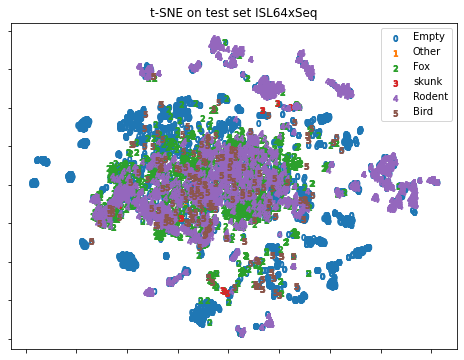

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i in range(6):
    marker = "$" + str(i) + "$"
    idx = labels == i
    ax.scatter(tsne_results[idx, 0], tsne_results[idx, 1], 
              marker=marker, color=cmap(i))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("t-SNE on test set ISL64xSeq")
plt.legend(["Empty", "Other", "Fox", "skunk", "Rodent", "Bird"], loc="upper right")

In [89]:
tsne_results3 = TSNE(n_components=3).fit_transform(results_test)

c:\Projects\pyvenvs\wildsenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Projects\pyvenvs\wildsenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [90]:
import plotly.express as px
# https://gist.github.com/UrusuLambda/3ad2b091dc4ada5f89a379ba7a1c5760
x_train_transformed_3d = tsne_results3
df_train=pd.DataFrame(x_train_transformed_3d[:, 0:3],columns=list("XYZ"))
df_train["label"]=np.array(labels_test).astype(str)


df_merged = pd.concat([df_train])
fig = px.scatter_3d(df_merged, x='X', y='Y', z='Z',  color='label', width=2000, height=1600, size_max=0.5, opacity=0.4)
fig.show()

In [91]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
# clf = svm.SVC(kernel='linear') # Linear Kernel
clf = svm.SVC(kernel='rbf') # rbf Kernel

#Train the model using the training sets
clf.fit(results_train, labels_train)

SVC()

In [92]:
ypred = clf.predict(results_test)

In [93]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(labels_test, ypred))

Accuracy: 0.715731905980917


In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
matrix = confusion_matrix(ypred, labels_test)
print('classwise accuracy:', matrix.diagonal()/matrix.sum(axis=1))

classwise accuracy: [0.84791496        nan 0.64561957        nan 0.60793434 0.        ]


C:\Users\jakob\AppData\Local\Temp\ipykernel_10464\3080975447.py:3: RuntimeWarning:

invalid value encountered in true_divide



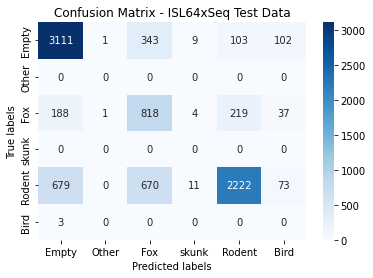

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap='Blues'); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - ISL64xSeq Test Data')
ax.xaxis.set_ticklabels(["Empty", "Other", "Fox", "skunk", "Rodent", "Bird"]); ax.yaxis.set_ticklabels(["Empty", "Other", "Fox", "skunk", "Rodent", "Bird"]);

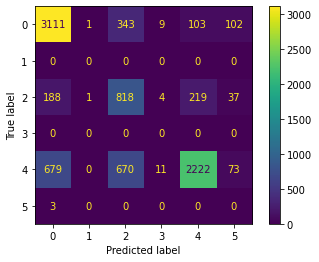

In [96]:
ConfusionMatrixDisplay(matrix).plot()

In [97]:
classification_report(labels_test, ypred, output_dict=True)

c:\Projects\pyvenvs\wildsenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Projects\pyvenvs\wildsenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Projects\pyvenvs\wildsenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



{'0': {'precision': 0.8479149632052331,
  'recall': 0.7814619442351168,
  'f1-score': 0.8133333333333334,
  'support': 3981},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2},
 '2': {'precision': 0.6456195737963694,
  'recall': 0.4467504096122338,
  'f1-score': 0.5280826339573919,
  'support': 1831},
 '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 24},
 '4': {'precision': 0.6079343365253078,
  'recall': 0.8734276729559748,
  'f1-score': 0.716889820938861,
  'support': 2544},
 '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 212},
 'accuracy': 0.715731905980917,
 'macro avg': {'precision': 0.350244812254485,
  'recall': 0.35027333780055425,
  'f1-score': 0.34305096470493107,
  'support': 8594},
 'weighted avg': {'precision': 0.7102936770143784,
  'recall': 0.715731905980917,
  'f1-score': 0.7014855721717997,
  'support': 8594}}

c:\Projects\pyvenvs\wildsenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Projects\pyvenvs\wildsenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Projects\pyvenvs\wildsenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



{'0': {'precision': 0.8479149632052331,
  'recall': 0.7814619442351168,
  'f1-score': 0.8133333333333334,
  'support': 3981},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2},
 '2': {'precision': 0.6456195737963694,
  'recall': 0.4467504096122338,
  'f1-score': 0.5280826339573919,
  'support': 1831},
 '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 24},
 '4': {'precision': 0.6079343365253078,
  'recall': 0.8734276729559748,
  'f1-score': 0.716889820938861,
  'support': 2544},
 '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 212},
 'accuracy': 0.715731905980917,
 'macro avg': {'precision': 0.350244812254485,
  'recall': 0.35027333780055425,
  'f1-score': 0.34305096470493107,
  'support': 8594},
 'weighted avg': {'precision': 0.7102936770143784,
  'recall': 0.715731905980917,
  'f1-score': 0.7014855721717997,
  'support': 8594}}

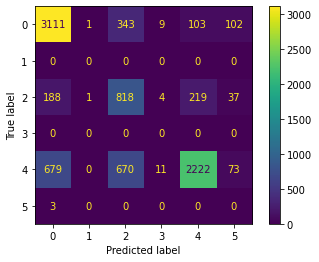

In [98]:
ConfusionMatrixDisplay(matrix).plot()
classification_report(labels_test, ypred, output_dict=True)

In [99]:
model = Encoder(3, 128, hidden_dims=[128, 128, 128])
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 1.647MB


In [32]:
param_size

1723392

In [33]:
p1 = "C:/temp/data_final/islands/images/ISL64xCropRGBTest20/"
p2 = "C:/temp/data_final/islands/images/ISL64xCropRGBVal20/"
p3 = "C:/temp/data_final/islands/images/ISL64xCropRGBTrain5/"

#check if each file from both paths are unique to the folder:
for i in glob.glob(p1 + '/*.jpg', recursive=True):
    if i in glob.glob(p2 + '/*.jpg', recursive=True):
        print(i)
        print('error')
        break
    else:
        print(i)
        print('ok')
        break 

# also check for p3
for i in glob.glob(p3 + '/*.jpg', recursive=True):
    if i in glob.glob(p1 + '/*.jpg', recursive=True):
        print(i)
        print('error')
        break
    else:
        print(i)
        print('ok')
        break

C:/temp/data_final/islands/images/ISL64xCropRGBTest20\00013173-89c1-41d2-93a8-5f8068ff26bd.jpg
ok
C:/temp/data_final/islands/images/ISL64xCropRGBTrain5\000f60ee-89c7-4637-a79b-cd342ee95068.jpg
ok
